### 安装依赖

In [2]:
!uv add langgraph ragas  nltk  

Resolved 185 packages in 5ms
Audited 178 packages in 0.14ms


### 1. 模型配置

1.1 环境变量配置

In [6]:
from pydantic_settings import BaseSettings, SettingsConfigDict
from pydantic import SecretStr


class Settings(BaseSettings):
    model_config = SettingsConfigDict(
        env_file=".env", env_file_encoding="utf-8", extra="ignore", case_sensitive=False
    )
    openai_api_key: SecretStr
    openai_base_url: str
    openai_model: str  # 评估用LLM
    openai_embedding_model: str  # 嵌入模型
    temperature: int = 0  # 固定随机种子，确保评估结果稳定


config = Settings()

1.2 配置模型

In [7]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI, OpenAIEmbeddings


llm = ChatOpenAI(
    base_url=config.openai_base_url,
    api_key=config.openai_api_key,
    model=config.openai_model,
    temperature=config.temperature,
)
embeddings = OpenAIEmbeddings(
    model=config.openai_embedding_model,
    base_url=config.openai_base_url,
    api_key=config.openai_api_key,
)

generator_llm = LangchainLLMWrapper(llm)
generator_embedding = LangchainEmbeddingsWrapper(embeddings=embeddings)

### 2. 构建 ReAct 代理核心组件
2.1 使用预定义 JSON 模拟金属价格数据

In [8]:
metal_price = {
    "gold": 88.1553,
    "silver": 1.0523,
    "platinum": 32.169,
    "palladium": 35.8252,
    "lbma_gold_am": 88.3294,
    "lbma_gold_pm": 88.2313,
    "lbma_silver": 1.0545,
    "lbma_platinum_am": 31.99,
    "lbma_platinum_pm": 32.2793,
    "lbma_palladium_am": 36.0088,
    "lbma_palladium_pm": 36.2017,
    "mcx_gold": 93.2689,
    "mcx_gold_am": 94.281,
    "mcx_gold_pm": 94.1764,
    "mcx_silver": 1.125,
    "mcx_silver_am": 1.1501,
    "mcx_silver_pm": 1.1483,
    "ibja_gold": 93.2713,
    "copper": 0.0098,
    "aluminum": 0.0026,
    "lead": 0.0021,
    "nickel": 0.0159,
    "zinc": 0.0031,
    "lme_copper": 0.0096,
    "lme_aluminum": 0.0026,
    "lme_lead": 0.002,
    "lme_nickel": 0.0158,
    "lme_zinc": 0.0031,
}

2.2 定义工具函数（LangChain 工具装饰器）

In [9]:
from langchain_core.tools import tool


@tool
def get_metal_price(metal_name: str) -> float:
    """获取指定金属的当前价格（美元/克）"""
    metal_name = metal_name.lower().strip()
    if metal_name not in metal_price:
        raise KeyError(
            f"金属'{metal_name}'未找到，可用金属：{', '.join(metal_price.keys())}"
        )
    return metal_price[metal_name]

2.3 绑定工具到 LLM（ChatOpenAI 模型）

In [ ]:
tools = [get_metal_price]
llm_with_tools = llm.bind_tools(tools)  # 将工具绑定到LLM

2.4 定义对话状态与流程控制
- 状态类（GraphState）：跟踪对话消息历史

In [13]:
from langgraph.graph import END
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated, TypedDict


class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]  # 存储对话消息列表

- 流程控制函数（should_continue）：判断是否继续工具调用

In [14]:
def should_continue(state: GraphState):
    """根据最后一条消息是否包含工具调用，决定是否继续对话"""
    last_message = state["messages"][-1]
    return "tools" if last_message.tool_calls else END  # 有工具调用则继续，否则结束

2.5 定义节点与构建状态图（StateGraph）
- 助手节点（生成 LLM 响应）

In [16]:
def assistant(state: GraphState):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}  # 返回包含新消息的状态

- 工具节点（管理工具执行）

In [17]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools)  # 初始化工具节点，传入get_metal_price工具

- 构建完整状态图

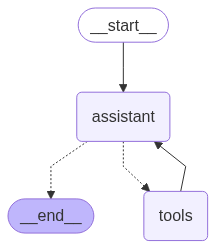

In [18]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display

builder = StateGraph(GraphState)  # 基于GraphState构建图

# 添加节点
builder.add_node("assistant", assistant)
builder.add_node("tools", tool_node)

# 定义边（流程走向）
builder.add_edge(START, "assistant")  # 起始于助手节点
builder.add_conditional_edges(
    "assistant", tools_condition
)  # 助手节点根据条件转向工具节点或结束
builder.add_edge("tools", "assistant")  # 工具调用后回到助手节点处理结果

react_graph = builder.compile()  # 编译状态图
display(
    Image(react_graph.get_graph(xray=True).draw_mermaid_png())
)  # 可视化图结构（生成流程图）

### 3. 代理执行与消息格式转换
3.1 运行代理并获取对话历史

In [20]:
from langchain_core.messages import HumanMessage

# 示例查询：铜价
messages = [HumanMessage(content="铜(copper)的价格是多少？")]
result = react_graph.invoke({"messages": messages})  # 执行状态图

# 输出对话历史（包含HumanMessage、AIMessage、ToolMessage）
print(result["messages"])

[HumanMessage(content='铜(copper)的价格是多少？', additional_kwargs={}, response_metadata={}, id='3522393c-1f18-48c7-96be-2d52f2227958'), AIMessage(content='<think>\n好的，用户问的是铜的价格。我需要调用get_metal_price这个函数来获取当前价格。首先，确认一下函数的参数，需要metal_name，类型是字符串。用户提到的金属是铜，所以参数应该是"metal_name": "copper"。然后按照格式返回工具调用的JSON。确保没有其他多余的信息，直接给出正确的工具调用结构。\n</think>\n\n', additional_kwargs={'tool_calls': [{'id': 'call_e9s54dn6', 'function': {'arguments': '{"metal_name":"copper"}', 'name': 'get_metal_price'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 110, 'prompt_tokens': 153, 'total_tokens': 263, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen3', 'system_fingerprint': 'fp_ollama', 'id': 'chatcmpl-735', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--623e908e-f917-4aac-bdd1-9ede6354349d-0', tool_calls=[{'name': 'get_metal_price', 'args': {'metal_name': 'copper'}, 'id': 'call_e9s54dn6', 't

3.2 转换为 Ragas 评估格式

In [21]:
from ragas.integrations.langgraph import convert_to_ragas_messages

ragas_trace = convert_to_ragas_messages(result["messages"])  # 转换为Ragas消息列表
# 输出格式：包含type（human/ai/tool）、content、tool_calls的结构化数据

In [22]:
ragas_trace

[HumanMessage(content='铜(copper)的价格是多少？', metadata=None, type='human'),
 AIMessage(content='<think>\n好的，用户问的是铜的价格。我需要调用get_metal_price这个函数来获取当前价格。首先，确认一下函数的参数，需要metal_name，类型是字符串。用户提到的金属是铜，所以参数应该是"metal_name": "copper"。然后按照格式返回工具调用的JSON。确保没有其他多余的信息，直接给出正确的工具调用结构。\n</think>\n\n', metadata=None, type='ai', tool_calls=[ToolCall(name='get_metal_price', args={'metal_name': 'copper'})]),
 ToolMessage(content='0.0098', metadata=None, type='tool'),
 AIMessage(content='<think>\n好的，现在用户问的是铜的价格，我需要先调用get_metal_price函数来获取最新的价格数据。根据之前的工具描述，这个函数需要传入metal_name参数，类型是字符串。用户的问题里明确提到了“铜(copper)”，所以参数应该是"copper"。接下来，我需要生成一个符合要求的tool_call结构，包含函数名和参数。然后，当用户给出响应0.0098时，我需要解析这个价格，并用自然的中文告诉用户当前铜的价格是每克0.0098美元。同时，可能需要提醒用户价格可能会波动，建议关注实时行情。确保回答简洁明了，符合用户的需求。\n</think>\n\n当前铜（copper）的价格是每克0.0098美元。需要注意的是，金属价格会实时波动，建议关注最新市场行情以获取准确信息。', metadata=None, type='ai', tool_calls=[])]

### 4. 代理性能评估（Ragas 指标）
4.1 工具调用准确性（Tool Call Accuracy）
- 目标：验证 LLM 是否正确调用工具及参数
- 代码实现：

In [23]:
from ragas.metrics import ToolCallAccuracy
from ragas.dataset_schema import MultiTurnSample
from ragas.messages import ToolCall

# 创建评估样本（指定预期工具调用）
sample = MultiTurnSample(
    user_input=ragas_trace,  # 转换后的Ragas消息列表
    reference_tool_calls=[
        ToolCall(name="get_metal_price", args={"metal_name": "copper"})
    ],
)

# 计算得分（1.0表示完全正确）
tool_accuracy_scorer = ToolCallAccuracy()
score = await tool_accuracy_scorer.multi_turn_ascore(sample)
print(f"Tool Call Accuracy: {score}")  # 输出：1.0

Tool Call Accuracy: 1.0


4.2 代理目标准确性（Agent Goal Accuracy）
- 目标：验证代理是否达成用户最终目标（如计算 10 克银价）
- 代码实现（以复杂查询为例）

In [24]:
from ragas.metrics import AgentGoalAccuracyWithReference
from ragas.llms import LangchainLLMWrapper

# 新查询：10克银价
messages = [HumanMessage(content="10 克白银(silver)的价格是多少？")]
result = react_graph.invoke({"messages": messages})
print(result["messages"])
ragas_trace = convert_to_ragas_messages(result["messages"])

# 创建样本（指定目标描述）
sample = MultiTurnSample(
    user_input=ragas_trace, reference="10 克白银的价格"  # 预期目标
)

# 初始化评估LLM并计算得分
evaluator_llm = LangchainLLMWrapper(llm)
scorer = AgentGoalAccuracyWithReference()
scorer.llm = evaluator_llm
score = await scorer.multi_turn_ascore(sample)
print(f"Agent Goal Accuracy: {score}")  # 输出：1.0（目标达成）

[HumanMessage(content='10 克白银(silver)的价格是多少？', additional_kwargs={}, response_metadata={}, id='1d1bd03e-b73f-49b1-ba70-60edcfdfd4bd'), AIMessage(content='<think>\n好的，用户问的是10克白银的价格是多少。首先，我需要确定用户需要的是当前价格，所以应该调用获取金属价格的函数。查看提供的工具，有一个get_metal_price函数，参数是metal_name。用户提到的白银对应的金属名称应该是silver。所以需要调用这个函数，参数设置为silver。然后，函数会返回价格，单位是美元/克。得到价格后，再乘以10克，得到总金额。最后用中文回答用户，显示总价格。需要确保步骤正确，参数正确，单位转换正确。\n</think>\n\n', additional_kwargs={'tool_calls': [{'id': 'call_xbm0uzes', 'function': {'arguments': '{"metal_name":"silver"}', 'name': 'get_metal_price'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 148, 'prompt_tokens': 157, 'total_tokens': 305, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen3', 'system_fingerprint': 'fp_ollama', 'id': 'chatcmpl-516', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--9ecd2ac5-de22-453f-ac9b-3c3bcfaf7dc2-0', tool_calls=[{'name': 'get_metal_pric